# Bonus Challenge: Spiral Data Classification

Now that you completed Challenge 2, you know you can use the Tensorflow Playground to experiment the hyperparameters of your deep learning model. If you are brave enough to take on this challenge, we present you the spiral data generated by codes and you will replicate your model built visually in the Tensorflow Playground with Python codes.

Below are the codes to generate the spiral dataset. Read the remarks and execute the codes.

In [1]:
from math import hypot, cos, sin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.metrics import cohen_kappa_score, classification_report 
from matplotlib.colors import ListedColormap
from keras.utils.np_utils import to_categorical

In [2]:
"""
A function to generate X/Y data points that will form a spiral.
"""
def spiral(radius, step, resolution=.1, angle=0.0, start=0.0):
    dist = start
    coords=[]
    while dist*hypot(cos(angle),sin(angle))<radius:
        cord=[]
        cord.append(dist*cos(angle))
        cord.append(dist*sin(angle))
        coords.append(cord)
        dist+=step
        angle+=resolution
    return coords

In [3]:
# Generate two sets of spiral data points with opposite angles
data_1 = np.array(spiral(1000, 5, angle=0))
data_2 = np.array(spiral(1000, 5, angle=180))

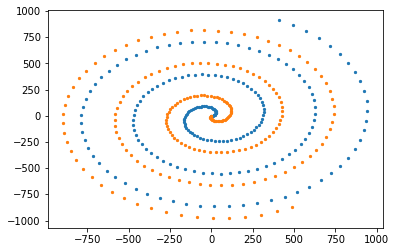

In [4]:
# Plot the two datasets to visualize the spirals

a, b = data_1.T
plt.scatter(a, b, s=5)

aa, bb = data_2.T
plt.scatter(aa, bb, s=5)

plt.show()

In [5]:
# Combine the two spiral datasets into one

df1 = pd.DataFrame(data=data_1, columns=["X", "Y"])
df1["CLASS"] = 0

df2 = pd.DataFrame(data=data_2, columns=["X", "Y"])
df2["CLASS"] = 1

df = df1.append(df2)
df['CLASS'].value_counts()

<ipython-input-5-b708e975e354>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


0    201
1    201
Name: CLASS, dtype: int64

Now, build a neural network with Tensorflow to classify `df`. See how low data loss and how high accuracy can you achieve!

In [6]:
df

,X,Y,CLASS
0,0.000000,0.000000,0
1,4.975021,0.499167,0
2,9.800666,1.986693,0
3,14.330047,4.432803,0
4,18.421220,7.788367,0
...,...,...,...
196,106.478547,-974.198296,1
197,204.240898,-963.592578,1
198,300.939178,-943.151955,1
199,395.581665,-912.984198,1


In [7]:
X = df[['X','Y']]
y = df['CLASS']

In [8]:
ros = RandomOverSampler(random_state=23, sampling_strategy='all')

X_over, y_over = ros.fit_resample(X, y)

In [9]:
print(X_over.shape, y_over.shape)

(402, 2) (402,)


In [10]:
X_sq = X.pow(2)

In [11]:
X_y = X['X']*X['Y']

In [12]:
X_sin = np.sin(X)

In [13]:
X_new = pd.concat([X, X_sq, X_y, X_sin], axis=1)
X_new.columns = ['X1','X2','X12','X22','Xy','X1sin','X2sin']
X_new.head()

,X1,X2,X12,X22,Xy,X1sin,X2sin
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.975021,0.499167,24.750832,0.249168,2.483367,-0.965710,0.478694
2,9.800666,1.986693,96.053050,3.946950,19.470917,-0.367099,0.914754
3,14.330047,4.432803,205.350257,19.649743,63.522278,0.981456,-0.961170
4,18.421220,7.788367,339.341342,60.658658,143.471218,-0.415358,0.997848


## Transformations to normalize data

**Power Transformer**

In [14]:
X_tr = PowerTransformer().fit_transform(X_new)
X_tr = pd.DataFrame(X_tr, columns = X_new.columns)

**MinMax Scaler**

In [15]:
X_mm = MinMaxScaler().fit_transform(X_tr)
X_mm = pd.DataFrame(X_mm, columns=X_new.columns) 

**X-Y Split**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_mm,y, test_size=0.5, random_state=23)

X_tr, X_te, y_tr, y_te= train_test_split(X,y, test_size=0.5, random_state=23)

In [17]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [18]:
def model_performance_class(y_train, y_pred_train):

    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))

In [19]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = np.min(X)[0] - 0.1, np.max(X)[0] + 0.1
    y_min, y_max = np.min(X)[1] - 0.1, np.max(X)[1] + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00'])

    Z = np.round(model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0))
    Z = Z[:,0].reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    y_color = [0 if x==1 else 1 for x in y]
    plt.scatter(X['X'], X['Y'], c=y_color, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## Creating the Neural Network

In [20]:
model = keras.Sequential()
model.add(Dense(units = 256, activation='relu', input_shape=(2,) ))
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 32, activation='relu'))
model.add(Dense(units = 16, activation='relu'))
model.add(Dense(units = 2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

y_cat = to_categorical(y_over)
history = model.fit(X_over, y_cat,epochs=1500, batch_size=32, verbose=3)

Epoch 1/1500
Epoch 2/1500
Epoch 3/1500
Epoch 4/1500
Epoch 5/1500
Epoch 6/1500
Epoch 7/1500
Epoch 8/1500
Epoch 9/1500
Epoch 10/1500
Epoch 11/1500
Epoch 12/1500
Epoch 13/1500
Epoch 14/1500
Epoch 15/1500
Epoch 16/1500
Epoch 17/1500
Epoch 18/1500
Epoch 19/1500
Epoch 20/1500
Epoch 21/1500
Epoch 22/1500
Epoch 23/1500
Epoch 24/1500
Epoch 25/1500
Epoch 26/1500
Epoch 27/1500
Epoch 28/1500
Epoch 29/1500
Epoch 30/1500
Epoch 31/1500
Epoch 32/1500
Epoch 33/1500
Epoch 34/1500
Epoch 35/1500
Epoch 36/1500
Epoch 37/1500
Epoch 38/1500
Epoch 39/1500
Epoch 40/1500
Epoch 41/1500
Epoch 42/1500
Epoch 43/1500
Epoch 44/1500
Epoch 45/1500
Epoch 46/1500
Epoch 47/1500
Epoch 48/1500
Epoch 49/1500
Epoch 50/1500
Epoch 51/1500
Epoch 52/1500
Epoch 53/1500
Epoch 54/1500
Epoch 55/1500
Epoch 56/1500
Epoch 57/1500
Epoch 58/1500
Epoch 59/1500
Epoch 60/1500
Epoch 61/1500
Epoch 62/1500
Epoch 63/1500
Epoch 64/1500
Epoch 65/1500
Epoch 66/1500
Epoch 67/1500
Epoch 68/1500
Epoch 69/1500
Epoch 70/1500
Epoch 71/1500
Epoch 72/1500
E

**Plotting the performance**

<Figure size 576x432 with 0 Axes>

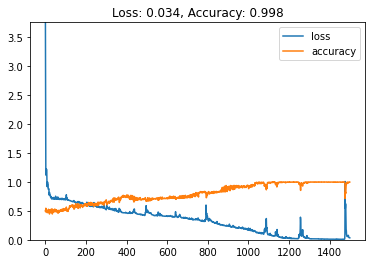

In [21]:
plot_loss_accuracy(history)

**Measuring the performance**

In [22]:
y_pred_tr = np.argmax(model.predict(X_over), axis=1).reshape(-1,1)
model_performance_class(y_over, y_pred_tr)

13/13 [==============================] - 0s 2ms/step
Results obtained for the TRAIN SET
The Cohen's Kappa is: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      1.00      1.00       201

    accuracy                           1.00       402
   macro avg       1.00      1.00      1.00       402
weighted avg       1.00      1.00      1.00       402



**Plotting the prediction model**

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


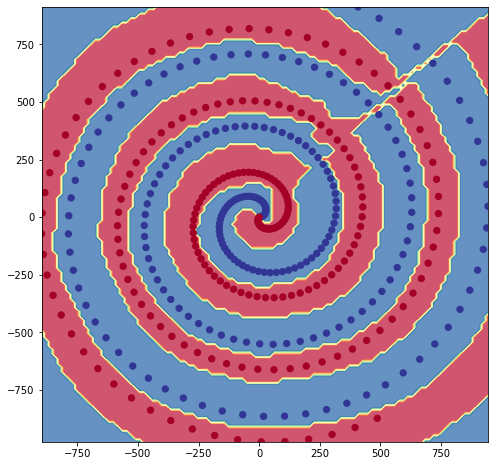

In [23]:
plot_multiclass_decision_boundary(model, X, y)